In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import time
import numpy as np
import xarray as xr
from itertools import product
from scipy.stats import pearsonr
import numpy as np
from numba import njit
from joblib import Parallel, delayed

## SWBM mit Runoff Delay und Performance Boost

Im bisherigen Model war die Runoff Funktion allein abhängig von Niederschlagsereignissen, an Tagen an denen kein Regen fiel konnte auch kein Runoff generiert werden. Dies führte zu einem starken Spike der Runoff Werte an diesen Regentagen, nur um danach direkt wieder auf null zu fallen. Die beobachtete Zeitreihe war jedoch deutlich konstanter, "smoother". 

Um dies zu addressieren, haben wir dem Model einen konstanten Baseflow IOTA hinzugefügt, damit Runoff auch unabhängig von Niederschlag gebildet werden kann. Dies hat zumindest in der Testzeitreihe zu starken Verbesserungen geführt.

Parallel lag es in der Natur unserer Untersuchung eine unglaubliche Anzahl an Iterationen des Models zu benötigen, um es vielerorts erfolgreich zu kalibirerien. Deshalb haben wir etwas Zeit beseite genommen, um das Model auch performance technisch zu boosten und so langfristig Zeit zu sparen.

Beides soll beispielhaft an dem Einzugsgebiet Bentfeld demonstriert werden.

In [7]:
# Alle Runoff Zeitreihen von GRDC
observed = xr.open_mfdataset(r"data/observed.nc").load()
observed = observed.sel(time=slice('2000-03-01', '2022-12-19'))
area = observed["area"].values

# Bentfeld spezifische Model Input Zeitreihen
temperature = xr.open_mfdataset(r'data/temperature.nc', combine='by_coords').load()
precipitation = xr.open_mfdataset(r'data/precipitation.nc', combine='by_coords').load()
radiation = xr.open_mfdataset(r'data/radiation.nc', combine='by_coords').load()
ndvi = xr.open_mfdataset(r'data/ndvi.nc', combine='by_coords').load()

# Kombiniertes Dataset über alle Gridcells
data = xr.Dataset()
data['temperature'] = temperature['t2m']
data['precipitation'] = precipitation['precipitation']
data['radiation'] = radiation['nr']
data['ndvi'] = ndvi['ndvi']
data = data.sel(time=slice('2000-03-01', '2022-12-19'))

# Mittelwerte der Inputzeitreihen -> Wird für Analyse verwendet
dataMean = data.mean(dim=("x", "y"))
# Einheiten umrechnen von m3/s zu mm/day
dataMean['observed'] = observed["runoff"]*86400/(area*1000)

dataMean

<xarray.Dataset> Size: 333kB
Dimensions:        (time: 8329)
Coordinates:
  * time           (time) datetime64[ns] 67kB 2000-03-01 ... 2022-12-19
    spatial_ref    int64 8B 0
    id             int32 4B 6335082
Data variables:
    temperature    (time) float32 33kB 277.0 275.4 277.4 ... 267.1 269.5 276.8
    precipitation  (time) float64 67kB 0.01154 0.001884 ... 0.0001641 0.005312
    radiation      (time) float64 67kB 3.049e+06 3.901e+06 ... -1.258e+05
    ndvi           (time) float64 67kB 0.375 0.388 0.4011 ... 0.4226 0.4427
    observed       (time) float32 33kB 2.808 3.054 3.008 3.127 ... nan nan nan

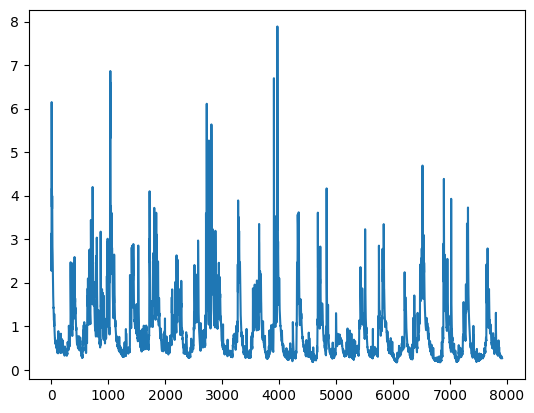

In [8]:
plt.plot(dataMean["observed"])
plt.show()

Das funktioniert mit der numba / njit Bibliothek, die Python Code kompiliert und dann direkt als Maschienencode ausführen kann. Dafür muss der gesamte Code möglichst in einer Funktion sein, weshalb das Model dementsprechend angepasst wurde

In [9]:
@njit
def time_evolution_numba(temp, rad, prec, ndvi, c_s, alpha, beta, gamma, c_m, iota, temp_w, ndvi_w):
    #Initialize 
    length = len(temp)
    runoff_out = np.full(length, np.nan)
    evapo_out = np.full(length, np.nan)
    soil_mois_out = np.full(length, np.nan)
    snow_out = np.full(length, np.nan)

    # Transformations / Calculations for Setup
    conv = 1 / 2260000  # from J/day/m**2 to mm/day
    rad = rad * conv  # convert radiation to mm/day
    prec = prec * 10 **3 # from m/day to mm/day
    w = 0.9 * c_s
    snow = 0

    # --- calc_et_weight function ---
    ndvi = np.nan_to_num(ndvi, nan=0.0)
    normalized_temp = (temp - temp.min()) / (temp.max() - temp.min())
    normalized_ndvi = (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())
    et_weight = temp_w * normalized_temp + ndvi_w * normalized_ndvi
    beta_weighted = beta * et_weight

    for t in range(1, length):
        prec_t = prec[t-1]
        temp_t = temp[t-1]
        rad_t = rad[t-1]
        beta_t = beta_weighted[t-1]

        # ---- snow_function ----
        is_melting = temp_t > 273.15
        has_snow = snow >= 0.001

        if not is_melting:
            snow = snow + prec_t
            water = 0.0
        elif is_melting and has_snow:
            melt = c_m * (temp_t - 273.15)
            melt = min(melt, snow)
            snow = snow - melt
            water = melt + prec_t
        else:
            water = prec_t

        # --- !!! ADDED IOTA HERE  !!! ----    
        runoff = (water + iota) * (w / c_s) ** alpha
        evap = beta_t * (w / c_s) ** gamma * rad_t

        w = w + (water - runoff - evap)
        w = np.maximum(w, 0.0)

        # Store results
        runoff_out[t] = runoff
        evapo_out[t] = evap
        soil_mois_out[t] = w
        snow_out[t] = snow

    return runoff_out, evapo_out, soil_mois_out, snow_out

Zur einfacheren Handhabung wurde die Funktion in eine Klasse eingebettet. Dies ist nicht unbedingt notwendig, stellt sogar ein gewisses Bottleneck da, ich finde den folgenden Kalibrierungs Code dann aber einfacher zu verstehen.

In [10]:
class WaterModel:
    def __init__(self, params: dict, data):
        self.params = params
        self.data = data

    def run_simulation_whole_catchment(self):
        runoff,_,_,_= time_evolution_numba(
            self.data['temperature'].values,
            self.data['radiation'].values,
            self.data['precipitation'].values,
            self.data['ndvi'].values,
            self.params['c_s'],
            self.params['alpha'],
            self.params['beta'],
            self.params['gamma'],
            self.params['c_m'],
            self.params['iota'],
            self.params['temp_w'],
            self.params['ndvi_w']
        )
        return runoff

Zum Vergleich soll auch das Original Wassermodel herangezogen werden, wie es uns von Pia bereitgestellt worden ist:

In [11]:
# Original SWBM aus dem Kurs

def calc_et_weight(temp, lai, w):
    """Calculate influence of LAI and temperature on ET.
    Input: temp: temperature data [K]
           lai: leaf area index data [m**2/m**2]
           w: weights for temperature and lai"""
    # Get coefficients for temperature and lai
    temp_w, lai_w = w
    lai = np.nan_to_num(lai, nan=0)
    temp_min = temp.min()
    temp_max = temp.max()
    lai_min = lai.min()
    lai_max = lai.max()

    # Perform normalization
    normalized_temp = (temp - temp_min) / (temp_max - temp_min)
    normalized_lai = (lai - lai_min) / (lai_max - lai_min)

    # Weight Temperature and LAI
    et_coef = temp_w * normalized_temp + lai_w * normalized_lai
    return et_coef

def water_balance(w_t, prec_t, rad_t, snow_t, temp_t, cs, alpha, beta, gamma, c_m):
    """ Calculates the water balance for one time step as introduced in the lecture. Added features, such as snow"""
    snow_t, prec_t = snow_function(snow_t, prec_t, temp_t,
                             c_m)  # overwrites the precipitation (if snow melts or precipitation is accumulated as snow)
    runoff_t = runoff(w_t, prec_t, cs, alpha)
    evapo_t = evapotranspiration(w_t, rad_t, cs, beta, gamma)
    w_next = w_t + (prec_t - evapo_t - runoff_t)
    w_next = np.maximum(0, w_next)
    
    return runoff_t, evapo_t, w_next, snow_t

def runoff(w_t, prec_t, cs, alpha):
    return prec_t * (w_t / cs) ** alpha

def evapotranspiration(w_t, rad_t, cs, beta, gamma):
    return beta * (w_t / cs) ** gamma * rad_t

def snow_function(snow_t, prec_t, temp_t, c_m):
    # Determine if temperature is above freezing (melting condition)
    is_melting = temp_t > 273.15
    
    # Determine if there is already snow on the ground
    has_snow = snow_t >= 0.001

    if not is_melting:
        # Temperature is below or at freezing → precipitation adds to snow
        snow_out = snow_t + prec_t
        water_out = 0.0
    elif is_melting and has_snow:
        # Snow is present and temperature is above freezing → melt snow
        SnowMelt = c_m * (temp_t - 273.15)
        snow_out = snow_t - SnowMelt
        if snow_out < 0:
            SnowMelt = snow_t  # Can't melt more than exists
            snow_out = 0.0
        water_out = SnowMelt + prec_t
    else:
        # No snow, and temperature above freezing → all precip is rain
        snow_out = snow_t
        water_out = prec_t

    return snow_out, water_out

def time_evolution(temp, rad, prec, lai, params):
    runoff_out = np.full_like(temp, np.nan)
    evapo_out = np.full_like(temp, np.nan)
    soil_mois_out = np.full_like(temp, np.nan)
    snow_out = np.full_like(temp, np.nan)
    
    if np.all(np.isnan(lai)):
        #edge case for no vegetation
        return runoff_out, evapo_out, soil_mois_out, snow_out
    cs, alpha, gamma, beta, c_m, et_weight = params
    #conversion factor

    conv = 1 / 2260000  # from J/day/m**2 to mm/day
    rad = rad * conv  # convert radiation to mm/day
    prec = prec * 10 **3 # from m/day to mm/day
    
    w_0 = 0.9 * cs
    snow_0 = 0
    
    beta_weighted = beta * calc_et_weight(temp, lai, et_weight)
    
    for t in range(1, len(temp)):
        prec_t = prec[t-1]
        temp_t = temp[t-1]
        rad_t = rad[t-1]
        beta_weighted_t = beta_weighted[t-1]
        runoff_out[t], evapo_out[t], soil_mois_out[t], snow_out[t] = water_balance(
            w_0, prec_t, rad_t, snow_0, temp_t, cs, alpha, beta_weighted_t, gamma, c_m)
        w_0 = soil_mois_out[t]
        snow_0 = snow_out[t]
        
    return runoff_out, evapo_out, soil_mois_out, snow_out

## Performance Vergleich neues und altes Model

Um die volle Kapazität von numba ausnutzen zu können muss der Code erst einmal "normal" durchlaufen. Die Geschwindigkeitssteigerung bekommt man erst im zweiten Durchlauf zu spüren, was aber gerade in der Schleife der Kalibrierung sehr gelegen kommt.

In [12]:
start_time = time.time()

params_old = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]
runoff_orig,_,_,_ = time_evolution(temp=dataMean["temperature"],
                            rad=dataMean["radiation"],
                            prec=dataMean["precipitation"],
                            lai=dataMean["ndvi"],
                            params=params_old)

duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")


calculations completed in 11.06216 seconds.


In [14]:
start_time = time.time()

params_new = {
    "c_s": 840,
    "alpha": 8,
    "gamma": 0.5,
    "beta": 0.8,
    "c_m": 2.0,
    "temp_w": 0.75,
    "ndvi_w": 0.5,
    "iota": 10
}
wm = WaterModel(params=params_new, data= dataMean)
runoff_delayed = wm.run_simulation_whole_catchment()

duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")

calculations completed in 0.00051 seconds.


In [15]:
# Filter for nans in ts, pearsonr functions doesnt like them
mask_orig = ~np.isnan(runoff_orig) & ~np.isnan(dataMean["observed"])
mask_delayed = ~np.isnan(runoff_delayed) & ~np.isnan(dataMean["observed"])

#Calculate Pearson R for old and new model
r_orig = pearsonr(runoff_orig[mask_orig], dataMean["observed"][mask_orig])[0]
r_delayed = pearsonr(runoff_delayed[mask_delayed], dataMean["observed"][mask_delayed])[0]
print("r original model: " + str(np.round(r_orig, 2)))
print("r delayed model: " + str(np.round(r_delayed, 2)))


r original model: 0.49
r delayed model: 0.87


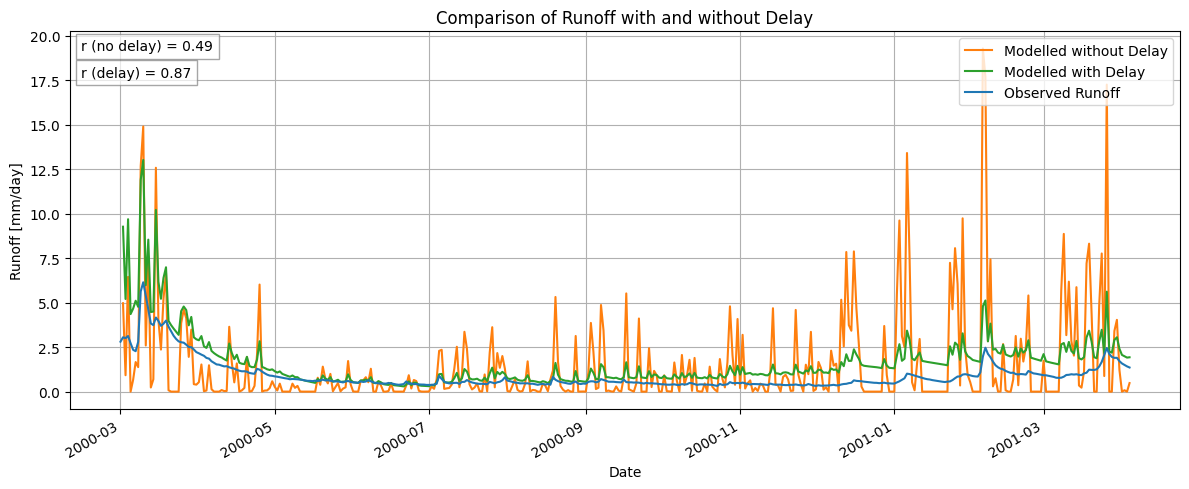

In [16]:
dates = dataMean["time"][:400].values
fig, ax = plt.subplots(figsize=(12, 5))

# Plot all series
ax.plot(dates, runoff_orig[:400], color='tab:orange', label="Modelled without Delay")
ax.plot(dates, runoff_delayed[:400], color='tab:green', label="Modelled with Delay")
ax.plot(dates, dataMean["observed"][:400], color='tab:blue', label="Observed Runoff")

# Labels and formatting
ax.set_title("Comparison of Runoff with and without Delay")
ax.set_xlabel("Date")
ax.set_ylabel("Runoff [mm/day]")
ax.grid(True)
ax.legend(loc="upper right")

# Pearson R Values
ax.text(0.01, 0.95, f"r (no delay) = {r_orig:.2f}", transform=ax.transAxes,
        fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
ax.text(0.01, 0.88, f"r (delay) = {r_delayed:.2f}", transform=ax.transAxes,
        fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

# Improve x-axis formatting
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Kalibrierung

Zur Beginn der Kalibrierung muss erst ein educated guess für ein gutes Parameter Set (initParams) gegeben werden. Daraus wird eine Anzahl an Auswahlmöglichkeiten generiert, die über eine definierte Anzahl an Interationen (numIter) immer weiter verfeinert wird. Es werden alle möglichen Kombinationen ausgetestet und die mit dem besten Pearson R für die nächste Iteration gespeichert. Um auch hier die Performance zu erhöhen wurde auf die joblib Bibliothek zurückgegriffen, welche mehrere Testläufe parallel ablaufen lassen kann.

In [81]:
class Calibrator:
    def __init__(self, initParams, rasterData, numIter = 3):
        self.params = initParams
        self.rasterData = rasterData
        self.numIter = numIter

    def create_paramsChoice(self, params, i):
        paramsChoice = {key: [
            value-value/(2**i),
            value, 
            value+value/(2**i)]
                for key, value in params.items()}
        return paramsChoice

    def split_data(self, data, splitPerc):
        leng = data.sizes["time"]
        maxYear = leng/365
        sample = np.random.randint(0, maxYear, int(maxYear*splitPerc))
        mask = np.zeros(leng, dtype=bool)
        for s in sample:
            mask[s*365:(s+1)*365] = True
        train = data.isel(time=np.where(~mask)[0])
        test = data.isel(time=np.where(mask)[0])

        return train, test

    def calibrate_iteration(self, paramsChoice, train):
        allCombinations = list(product(*paramsChoice.values()))
        param_dicts = [dict(zip(paramsChoice.keys(), combo)) for combo in allCombinations]

        observed = train["observed"].values
        nan_mask_obs = ~np.isnan(observed)        

        def evaluate(params):
            wm = WaterModel(params=params, data=train)
            runoff = wm.run_simulation_whole_catchment()
            mask = nan_mask_obs & ~np.isnan(runoff)

            r, _ = pearsonr(runoff[mask], observed[mask])
            return params, r
        
        # --- !!! Parallelisierung !!! ---
        results = Parallel(n_jobs=-1)(delayed(evaluate)(params) for params in param_dicts)
        best_params, rTrain = max(results, key=lambda x: x[1])
        
        return best_params, rTrain
    
    def run_calibration(self):
        train, test = self.split_data(self.rasterData, 0.8)
        lParams = []
        lRTest = []
        lRTrain = []

        for i in range(1,self.numIter+1):
            paramsChoice = self.create_paramsChoice(self.params, i)
            newParams, rTrain = self.calibrate_iteration(paramsChoice, train)
            self.params = newParams
            lParams.append(newParams)

            wm = WaterModel(params=lParams[i-1], data=test)
            runoff = wm.run_simulation_whole_catchment()
            observed = test["observed"].values
            mask = ~np.isnan(observed)  & ~np.isnan(runoff)

            rTest, _ = pearsonr(runoff[mask], observed[mask])
            
            lRTest.append(rTest)
            lRTrain.append(rTrain)
        
        plt.plot(lRTest, label="test")
        plt.plot(lRTrain, label="train")
        plt.legend()
        plt.show()

        print("number of model runs: " + str(self.numIter*len(list(product(*paramsChoice.values())))))

        return lParams[-1], lRTest[-1]

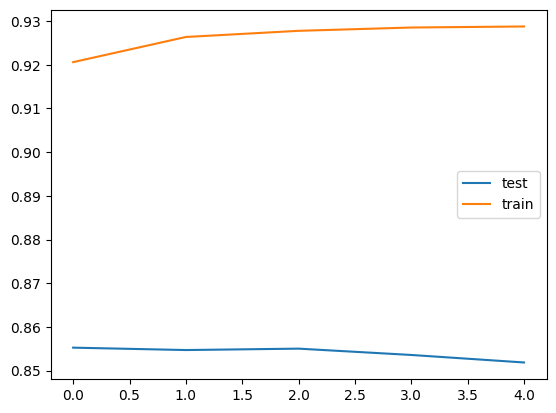

number of model runs: 32805
calculations completed in 4.29843 seconds.
c_s: 1035.439
alpha: 18.49
gamma: 0.149
beta: 1.547
c_m: 1.211
temp_w: 0.308
ndvi_w: 0.386
iota: 19.922


In [83]:
start_time = time.time()
cal = Calibrator(initParams=params_new, rasterData=dataMean, numIter=5)
paramsBest, r = cal.run_calibration()
duration = time.time() - start_time

print(f"calculations completed in {duration:.5f} seconds.")
for key, value in paramsBest.items():
    print(key + ": " + str(np.round(value, 3)))